# Capstone Project part 2: EDA  #
## Chalmer Lowe

** README ** 

The analysis of computer behavior (both the behavior of individual hosts and the behavior of traffic crossing between hosts) is fundamental to performing cyber security analysis. This EDA session evaluates a portion of the data from a Los Alamos National Labs data set comprising 90 days of host-based data collection and 90 days of network traffic. Due to the extremely large data set, we opted to limit our analysis to a subset of the total data that was collected on day 90. We attempted to include only data from the hosts and the network that fell within the same time slot (from xx:xx to xx:xx). This subset of data was chosen as a means of decreasing the overall data processing time needed.

Our subset of the data is included for use with this notebook.

** EDA comment by instructor**


## Step 0: What are you working on
** Your project title: Who and What: an assessment of the behavior on and between hosts on a network**  

Several questions have come to mind as part of this EDA:
* Is there a relationship between specific hosts and the number of packets sent?
* Is there a relationship between specific hosts and the number of bytes sent?

** What are the outcomes of your project: **  
** Data Source:(provide a link to dataset if available)** 
The original data for this project came from XXX:

In [1]:
'''
Time	The start time of the event in epoch time format
Duration	The duration of the event in seconds.
SrcDevice	The device that likely initiated the event.
DstDevice	The receiving device.
Protocol	The protocol number.
SrcPort	The port used by the SrcDevice.
DstPort	The port used by the DstDevice.
SrcPackets	The number of packets the SrcDevice sent during the event.
DstPackets	The number of packets the DstDevice sent during the event.
SrcBytes	The number of bytes the SrcDevice sent during the event.
DstBytes'''

'\nTime\tThe start time of the event in epoch time format\nDuration\tThe duration of the event in seconds.\nSrcDevice\tThe device that likely initiated the event.\nDstDevice\tThe receiving device.\nProtocol\tThe protocol number.\nSrcPort\tThe port used by the SrcDevice.\nDstPort\tThe port used by the DstDevice.\nSrcPackets\tThe number of packets the SrcDevice sent during the event.\nDstPackets\tThe number of packets the DstDevice sent during the event.\nSrcBytes\tThe number of bytes the SrcDevice sent during the event.\nDstBytes'

**Load packages:**

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
%matplotlib inline

#more packages import as needed

<a id='load_data'></a>

### 1. Load the data

---

Import the csv into a pandas DataFrame.

In [3]:
# As noted in the Readme, above, there was significantly more data available than could be
# conveniently processed and shared as part of this project. For that reason, I did some 
# fast and dirty preprocessing to reduce the number of records for both of the data files.
# The netflow data was reduced to ~3 million records between two time stamps
# The host data was reduced to ~1 million records between roughly the same time stamps
#     Additional processing below will be used to ensure that only records actually 
#     associated with the same time windows will be used in this assessment.

In [4]:
# The first dataset we will look at is the host data:
# This JSON-based file provides column headers based on the keys in the 
#     JSON. The file contains multiple JSON objects, one per line.

HOSTDATA = 'wls_day-90_217K'

dfhost = pd.read_json(HOSTDATA, lines=True)

In [5]:
# The second dataset we will look at is the netflow data:
# This CSV-based file does not have headers built-in, for this reason,
#     we will provide our own header names.

names = ['Time',
         'Duration',
         'SrcDevice',
         'DstDevice',
         'Protocol',
         'SrcPort',
         'DstPort',
         'SrcPackets',
         'DstPackets',
         'SrcBytes',
         'DstBytes',
        ]

NETDATA = 'netflow_day-90_680K'

dfnet = pd.read_csv(NETDATA, names=names)

### 2. Describe the basic format of the data and the columns

---

Use the `.head()` function (and optionally pass in an integer for the number of rows you want to see) to examine what the loaded data looks like. This is a good initial step to get a feel for what is in the csv and what problems may be present.

The `.dtypes` attribute tells you the data type for each of your columns.

Describe what you see

In [6]:
dfhost.head()

,AuthenticationPackage,Destination,DomainName,EventID,FailureReason,LogHost,LogonID,LogonType,LogonTypeDescription,ParentProcessID,...,ProcessID,ProcessName,ServiceName,Source,Status,SubjectDomainName,SubjectLogonID,SubjectUserName,Time,UserName
0,None,None,Domain001,4688,None,Comp883506,0x3e7,NaN,None,0x4db8,...,0x4140,wermgr.exe,None,None,None,None,None,None,7689600,Comp883506$
1,None,None,Domain001,4688,None,Comp154941,0x3e7,NaN,None,0x3b60,...,0x36c4,Proc857443.exe,None,None,None,None,None,None,7689600,Comp154941$
2,None,None,Domain001,4688,None,Comp055724,0x3e7,NaN,None,0x3c8,...,0xbfc,taskeng.exe,None,None,None,None,None,None,7689600,Comp055724$
3,None,None,Domain001,4769,None,ActiveDirectory,None,NaN,None,None,...,None,None,ActiveDirectory$,Comp230907,0x0,None,None,None,7689600,Comp230907$
4,Kerberos,None,Domain001,4624,None,ActiveDirectory,0xf014029,3.0,Network,None,...,None,None,None,Comp230907,None,None,None,None,7689600,Comp230907$


In [7]:
dfnet.head()

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
0,7689600,0,Comp580697,Comp275646,17,Port08290,53,1,0,75,0
1,7689600,0,Comp580697,Comp275646,17,Port81132,53,1,0,75,0
2,7689600,0,Comp580697,Comp275646,17,Port21353,53,1,0,75,0
3,7689600,0,Comp258829,Comp388094,6,Port81881,Port75515,0,3,0,144
4,7689600,0,Comp819564,Comp576031,17,Port10711,514,1,0,245,0


In [8]:
dfhost.dtypes

AuthenticationPackage     object
Destination               object
DomainName                object
EventID                    int64
FailureReason             object
LogHost                   object
LogonID                   object
LogonType                float64
LogonTypeDescription      object
ParentProcessID           object
ParentProcessName         object
ProcessID                 object
ProcessName               object
ServiceName               object
Source                    object
Status                    object
SubjectDomainName         object
SubjectLogonID            object
SubjectUserName           object
Time                       int64
UserName                  object
dtype: object

In [9]:
dfnet.dtypes

Time           int64
Duration       int64
SrcDevice     object
DstDevice     object
Protocol       int64
SrcPort       object
DstPort       object
SrcPackets     int64
DstPackets     int64
SrcBytes       int64
DstBytes       int64
dtype: object

---

Use the `.info()` function  to see how many rows and data types you got. This will also tell you how many rows of each column have content

Describe what you see

In [10]:
dfhost.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217000 entries, 0 to 216999
Data columns (total 21 columns):
AuthenticationPackage    66791 non-null object
Destination              6478 non-null object
DomainName               217000 non-null object
EventID                  217000 non-null int64
FailureReason            608 non-null object
LogHost                  217000 non-null object
LogonID                  191599 non-null object
LogonType                103788 non-null float64
LogonTypeDescription     103788 non-null object
ParentProcessID          64386 non-null object
ParentProcessName        64386 non-null object
ProcessID                75216 non-null object
ProcessName              75216 non-null object
ServiceName              7644 non-null object
Source                   66966 non-null object
Status                   25090 non-null object
SubjectDomainName        6333 non-null object
SubjectLogonID           6481 non-null object
SubjectUserName          6333 non-null obje

In [11]:
dfnet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680000 entries, 0 to 679999
Data columns (total 11 columns):
Time          680000 non-null int64
Duration      680000 non-null int64
SrcDevice     680000 non-null object
DstDevice     680000 non-null object
Protocol      680000 non-null int64
SrcPort       680000 non-null object
DstPort       680000 non-null object
SrcPackets    680000 non-null int64
DstPackets    680000 non-null int64
SrcBytes      680000 non-null int64
DstBytes      680000 non-null int64
dtypes: int64(7), object(4)
memory usage: 62.3+ MB


In [12]:
dfhost.describe(include=np.number)

,EventID,LogonType,Time
count,217000.000000,103788.000000,2.170000e+05
mean,4667.053221,3.011022,7.689781e+06
std,46.297830,0.444144,1.123760e+02
min,4624.000000,2.000000,7.689600e+06
25%,4634.000000,3.000000,7.689679e+06
50%,4648.000000,3.000000,7.689784e+06
75%,4688.000000,3.000000,7.689882e+06
max,4803.000000,9.000000,7.689968e+06


In [13]:
dfhost.describe(include=object)

,AuthenticationPackage,Destination,DomainName,FailureReason,LogHost,LogonID,LogonTypeDescription,ParentProcessID,ParentProcessName,ProcessID,ProcessName,ServiceName,Source,Status,SubjectDomainName,SubjectLogonID,SubjectUserName,UserName
count,66791,6478,217000,608,217000,191599,103788,64386,64386,75216,75216,7644,66966,25090,6333,6481,6333,217000
unique,4,97,32,4,7511,59805,7,5040,182,7916,381,512,5466,6,10,121,223,10452
top,Kerberos,Comp457365,Domain001,An Error occured during Logon.,ActiveDirectory,0x3e7,Network,0x12f4,svchost,0x2860,cmd.exe,Comp916004$,Comp916004,0x0,Domain001,0x3e7,Administrator,AppService
freq,38898,3297,208661,266,78863,61607,98856,2062,19221,3234,9239,2190,10386,24413,6094,2580,2480,34603


In [14]:
dfnet.describe(include=np.number)

,Time,Duration,Protocol,SrcPackets,DstPackets,SrcBytes,DstBytes
count,6.800000e+05,680000.000000,680000.000000,6.800000e+05,6.800000e+05,6.800000e+05,6.800000e+05
mean,7.689771e+06,286.727428,9.391049,1.892920e+02,2.647250e+02,3.424752e+04,1.901783e+05
std,1.101649e+02,2911.013155,5.081883,4.170094e+04,7.691827e+04,5.917214e+06,5.497951e+07
min,7.689600e+06,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.689672e+06,0.000000,6.000000,1.000000e+00,0.000000e+00,7.400000e+01,0.000000e+00
50%,7.689761e+06,1.000000,6.000000,4.000000e+00,1.000000e+00,2.810000e+02,6.000000e+01
75%,7.689869e+06,6.000000,17.000000,6.000000e+00,5.000000e+00,1.082000e+03,7.720000e+02
max,7.689971e+06,85892.000000,17.000000,1.709551e+07,3.618671e+07,2.579655e+09,2.766917e+10


In [15]:
dfnet.describe(include=object)

,SrcDevice,DstDevice,SrcPort,DstPort
count,680000,680000,680000,680000
unique,11692,6911,63359,10513
top,Comp030334,Comp275646,Port13777,80
freq,52527,97682,2836,106734


<a id='drop'></a>

### 2. Drop unwanted columns

---
You may want to focus on selected columns as your input features. You can drop those unwanted columns.

The `.drop()` built-in function can be used to get rid of a column. When removing a column, we need to specify `axis=1` to the function.

For the record, the `.index` attribute holds the row indices. This is the the sister attribute to the `.columns` attribute that we work with more often.



In [59]:
# I was very curious to see the relationships between the LogonTypes and the
#     LogonTypeDescription, so I filtered the dflogons DataFrame to:
#     * drop duplicates
#     * drop Null values
#     * and then to sort by the LogonType

dflogons = dfhost[['LogonType', 'LogonTypeDescription']]
dflogons.drop_duplicates().dropna().sort_values(by='LogonType')

,LogonType,LogonTypeDescription
105,2.0,Interactive
4,3.0,Network
72,4.0,Batch
43,5.0,Service
163008,7.0,Unlock
1049,8.0,NetworkClearText
57793,9.0,NewCredentials


In [60]:
# This led me to explore the frequency of each Logon Type:

dfhost.LogonTypeDescription.value_counts()

Network             98856
Interactive          3385
Service               783
NetworkClearText      535
Batch                 214
Unlock                  8
NewCredentials          7
Name: LogonTypeDescription, dtype: int64

In [61]:
# During the initial evaluation of the columns, I noted that there were 
#     reasons associated with failed logons.
# I wanted to see what types of reasons were recorded:

dfhost.FailureReason.value_counts()

An Error occured during Logon.                                             266
Unknown user name or bad password.                                         235
The user has not been granted the requested logon type at this machine.    103
Account currently disabled.                                                  4
Name: FailureReason, dtype: int64

In [69]:
# Similarly, I was curious how many domains the network was divided into:

dfhost.DomainName.value_counts().sort_index()


Comp032135                 72
Comp125736                329
Comp146253                  1
Comp307946                  8
Comp308413                 17
Comp349403                  2
Comp350644                  8
Comp399620                  3
Comp455286                  3
Comp567356                  1
Comp585184                  8
Comp586392                  1
Comp601512                  4
Comp721756                  1
Comp735514                  5
Comp743141                  8
Comp862246                  8
Comp882724                  1
Comp896931                  1
Comp902403                  1
Comp907587                 20
Comp923957                 10
Comp966901                  1
Comp981237                  1
Domain001              208661
Domain002                1112
Domain003                  10
Domain005                  35
EnterpriseAppServer      2838
nt authority             3804
nt service                 24
workgroup                   2
Name: DomainName, dtype: int64

In [75]:
# Based on these results, I felt like I wanted to focus some further investigation 
# on the Domains with what appear to be "official-sounding" domain names: Domain001, Domain002

dfdomains = dfhost[dfhost['DomainName'].str.contains('Domain')]
dfdomains.DomainName.value_counts()

Domain001    208661
Domain002      1112
Domain005        35
Domain003        10
Name: DomainName, dtype: int64

In [16]:
# Switching gears a bit... let's look at some of the data related to the Hosts.

# To evaluate a possible relationship between the number of packets sent
#     and the number of bytes sent, we will retain those solely those columns

In [17]:
# Remove any unnecessary column(s):

dfpnb = dfnet.drop(columns=['Duration', 'Protocol', 'SrcPort', 'DstPort'])

dfpnb.head()

,Time,SrcDevice,DstDevice,SrcPackets,DstPackets,SrcBytes,DstBytes
0,7689600,Comp580697,Comp275646,1,0,75,0
1,7689600,Comp580697,Comp275646,1,0,75,0
2,7689600,Comp580697,Comp275646,1,0,75,0
3,7689600,Comp258829,Comp388094,0,3,0,144
4,7689600,Comp819564,Comp576031,1,0,245,0


### 3. Clean corrupted columns (if there is any)

---

Did you notice when you examined the `dtypes` attribute that some of the columns were of type "object", indicating that they were string. For some case, these columns should be numeric instead.

It is pretty common to have numeric columns represented as strings in your data if some of the observations are corrupted. It is important to always check the data types of your columns.

In [18]:
# The content in each of the columns was uniform and appears to be correctly categorized as
#     strings/objects vs numbers.
# No special cleaning was necessary for the dfnet DataFrame


### 4. Determine how many observations are missing

---

When we start to build models with data, null values in observations are (almost) never allowed. It is important to always see how many observations are missing and for which columns.

A handy way to look at how many null values there are per column with pandas is:

```python
boston.isnull().sum()
```

The `.isull()` built-in function will convert the columns to boolean `True` and `False` values (returning a new dataframe) where null values are indicated by `True`. 

The `.sum()` function tacked on to the back of that will then sum these boolean columns, and the total number of null values per column will be returned.

In [81]:
# Exploring the dfdomain records that have null values:
# I first wanted to confirm how many total records were in the dfdomains DataFrame:

print(len(dfdomains))

# Based on this, we can see which columns seem to have the most missing data:
# Generally, what this tells me is that event records may vary widely:
#     certain details may not be required OR available in some records

# I am not sure yet, how I want to use this data, so I am going to leave it as is...

dfdomains.isnull().sum()

209818


AuthenticationPackage    145692
Destination              203647
DomainName                    0
EventID                       0
FailureReason            209293
LogHost                       0
LogonID                   25319
LogonType                110484
LogonTypeDescription     110484
ParentProcessID          146224
ParentProcessName        146224
ProcessID                136792
ProcessName              136792
ServiceName              202174
Source                   144731
Status                   184728
SubjectDomainName        203795
SubjectLogonID           203647
SubjectUserName          203795
Time                          0
UserName                      0
dtype: int64

In [19]:
# By contrast, in looking at our packets and bytes DataFrame:
#     There are no null values in the dfpnb DataFrame, these records 
#     are much more uniform, regular and consistent.

dfpnb.isnull().sum()

Time          0
SrcDevice     0
DstDevice     0
SrcPackets    0
DstPackets    0
SrcBytes      0
DstBytes      0
dtype: int64

**Drop the null values.** 

In this case, lets keep it simple and just drop the rows from the dataset that contain null values. If a column has a ton of null values it often makes more sense to drop the column entirely instead of the rows with null values. In this case, we will just drop the rows.

The `.dropna()` function will drop any rows that have _**ANY**_ null values for you.  Use this carefully as you could drop many more rows than expected.

** Instead of dropping null values, you may want to impute them (replace with the mean(numeric type) or most frequently occured item(object type) **

In [20]:
# use df.shape to check the size before dropping anything

In [21]:
# Now drop the rows with null values
# df.dropna(inplace=True)
# check the new size after dropping by df.shape

### 5. Make the column names more descriptive

---

Often it is annoying to have to memorize what the codes mean for columns, or reference the codebook whenever I want to know the meaning of a variable. It often makes sense to rename columns that are not descriptive.

There is more than one way to do this, but one easy way is to use the `.rename()` function.


In [83]:
# The dfhost columns are already well-named. No change needed.

dfdomains.columns

Index(['AuthenticationPackage', 'Destination', 'DomainName', 'EventID',
       'FailureReason', 'LogHost', 'LogonID', 'LogonType',
       'LogonTypeDescription', 'ParentProcessID', 'ParentProcessName',
       'ProcessID', 'ProcessName', 'ServiceName', 'Source', 'Status',
       'SubjectDomainName', 'SubjectLogonID', 'SubjectUserName', 'Time',
       'UserName'],
      dtype='object')

In [22]:
# I named the columns when I created the dfnet DataFrame (which the dfpnb DataFrame)
#     is based on, so this step is not necessary.

dfpnb.columns

Index(['Time', 'SrcDevice', 'DstDevice', 'SrcPackets', 'DstPackets',
       'SrcBytes', 'DstBytes'],
      dtype='object')

<a id='describe'></a>

### 6. Describe the summary statistics for the columns

---

The `.describe()` function gives summary statistics for each of your variables. What are some, if any, oddities you notice about the variables based on this output?

In [88]:
# For each of my primary DataFrames, I evaluated the summary statistics from two
#     perspectives: 
#     * numerical values (generically represented by the numpy number types)
#     * string values (generically represented by the pandas object type)


In [84]:
dfdomains.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
EventID,209818.0,4.667792e+03,46.702380,4624.0,4634.0,4648.0,4688.0,4803.0
LogonType,99334.0,2.997624e+00,0.407976,2.0,3.0,3.0,3.0,9.0
Time,209818.0,7.689781e+06,112.481850,7689600.0,7689679.0,7689784.0,7689883.0,7689968.0


In [85]:
dfdomains.describe(include=object).T

,count,unique,top,freq
AuthenticationPackage,64126,4,Kerberos,38898
Destination,6171,97,Comp457365,2990
DomainName,209818,4,Domain001,208661
FailureReason,525,4,An Error occured during Logon.,266
LogHost,209818,7507,ActiveDirectory,78212
LogonID,184499,57836,0x3e7,59939
LogonTypeDescription,99334,6,Network,95795
ParentProcessID,63594,5023,0x12f4,2062
ParentProcessName,63594,173,svchost,19192
ProcessID,73026,7880,0x2860,3234


In [25]:
dfpnb.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
Time,680000.0,7.689771e+06,1.101649e+02,7689600.0,7689672.0,7689761.0,7689869.0,7.689971e+06
SrcPackets,680000.0,1.892920e+02,4.170094e+04,0.0,1.0,4.0,6.0,1.709551e+07
DstPackets,680000.0,2.647250e+02,7.691827e+04,0.0,0.0,1.0,5.0,3.618671e+07
SrcBytes,680000.0,3.424752e+04,5.917214e+06,0.0,74.0,281.0,1082.0,2.579655e+09
DstBytes,680000.0,1.901783e+05,5.497951e+07,0.0,0.0,60.0,772.0,2.766917e+10


In [26]:
dfpnb.describe(include=object).T

,count,unique,top,freq
SrcDevice,680000,11692,Comp030334,52527
DstDevice,680000,6911,Comp275646,97682


### 7. Plot variables with potential outliers using boxplots.

---
You can use the seaborn package to plot boxplots of the variables we have identified as potentially having outliers.

Some notes on seaborn's boxplot keyword argument options:

    orient: can be 'v' or 'h' for vertical and horizontal, respectively
    fliersize: the size of the outlier points (pixels I think)
    linewidth: the width of line outlining the boxplot
    notch: show the confidence interval for the median (calculated by seaborn/plt.boxplot)
    saturation: saturate the colors to an extent
** What did you see and conclude out these boxplots?

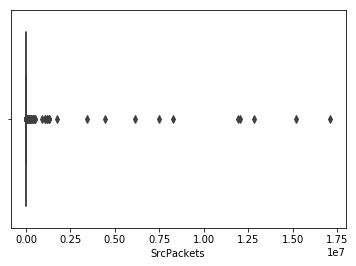

In [29]:
# I attempted to use a boxplot, but due to the scale and the variety of values, the results were not
#     overwhelmingly useful for looking at the number of SrcPackets.
# The other values are likely to have similar problems.
# This not unexpected, based on the minimum, maximum, mean and standard deviation
#     we saw for the various variables.

ax = sns.boxplot(x='SrcPackets', data=dfpnb)

### 8.Other relevants plots 

---
What can you infer out of these additonal plots as related to your problem?

[2.0, 3.0, 4.0, 7.0, 8.0, 9.0]
2.0     2972
3.0    95795
4.0       23
7.0        8
8.0      535
9.0        1
Name: LogonType, dtype: int64


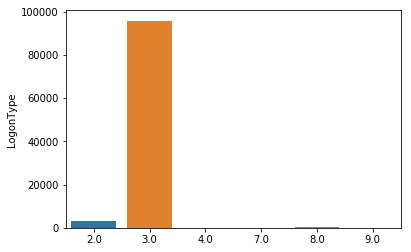

In [113]:
# In considering possible plots, a visual representation of the number of 
#     LogonTypes seemed like a good place to experiment, but as the results show...
#     the disparity in values renders the plot mostly useless.

x = sorted(dfdomains.LogonType.dropna().unique())
print(x)
y = dfdomains.LogonType.value_counts().sort_index()
print(y)
sns.barplot(x=x, y=y, data=dfdomains, orient='v')


<a id='standardization'></a>

### 9. Standardizing variables

---

Rescaling variables is very common, and sometimes essential. For example, when we get to regularization of models the rescaling procedure becomes a requirement before fitting the model.

Here we'll rescale the variables using a procedure called "standardization", which forces the distribution of each variable to have a mean of 0 and a standard deviation of 1.

Standardization is not complicated:

    standardized_variable = (variable - mean_of_variable) / std_dev_of_variable
    
Note: Nothing else is changed about the distribution of the variable. It doesn't become normally distributed.


Also print out the mean and standard deviation of the original variable.

In [32]:
# select the columns out of your dataframe to be standardized (usually it will be your input features)
# X= df[['column1','column2', 'more if needed']]
#check its mean and standard deviation before standardizing
# X.mean()
# X.std()

X = dfpnb[['SrcPackets', 'DstPackets', 'SrcBytes', 'DstBytes']]
print(X.mean())
print(X.std())



SrcPackets       189.291954
DstPackets       264.725031
SrcBytes       34247.516318
DstBytes      190178.331859
dtype: float64
SrcPackets    4.170094e+04
DstPackets    7.691827e+04
SrcBytes      5.917214e+06
DstBytes      5.497951e+07
dtype: float64


In [33]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
#check its mean and standard deviation after standardizing
#X_standardized.mean()
# X_standardized.std()
#What difference did you see? Describe here

print(X_standardized.mean())
print(X_standardized.std())


-1.72615190115e-19
1.0


In [41]:
# I was curious about what we get out of the scaler.fit_transform function, so
#     I displayed the help documentation, which indicated that
#     the function returns a numpy array with the same shape as the input
#     X.
# But, Jupyter Notebooks tend to not display those as well as DataFrames, so
#     just for kicks, I displayed the X_standardized array as a DataFrame


pd.DataFrame(X_standardized).head()

,0,1,2,3
0,-0.004515,-0.003442,-0.005775,-0.003459
1,-0.004515,-0.003442,-0.005775,-0.003459
2,-0.004515,-0.003442,-0.005775,-0.003459
3,-0.004539,-0.003403,-0.005788,-0.003456
4,-0.004515,-0.003442,-0.005746,-0.003459


### 10. Correlation matrices

---

A great way to easily get a feel for linear relationships between your variables is with a correlation matrix.



####  Correlation


A much more common metric, and one directly calculable from the covariance, is the correlation.

Again, let $X$ and $Y$ be our two variables, with covariance $cov(X, Y)$ that we calculated above:

### $$ \text{pearson correlation}\;r = cor(X, Y) =\frac{cov(X, Y)}{std(X)std(Y)}$$



#### The correlation matrix

We can see the correlation between all the numeric variables in our dataset by using pandas DataFrame's built in `.corr()` function. Use it below on the boston dataset.

It is very useful to get a feel for what is related and what is not, which can help you decide what is worth investigating further (though with a lot of variables, the matrix can be a bit overwhelming...)

In [42]:
# The strongest correlations in this output are between the number of Src packets and the
#     number of Src bytes OR between the number of Dst packets and the number of Dst bytes

# This relationship makes sense: one might logically conclude that the more packets you 
#     send, the more bytes you will also be sending.

# NOTE: theoretically, it is possible to send small numbers of very large packets 
#     and thus throw off the curve, that does not appear to be the case here.

dfpnb.corr()

,Time,SrcPackets,DstPackets,SrcBytes,DstBytes
Time,1.000000,0.001082,0.001079,-0.000462,0.001643
SrcPackets,0.001082,1.000000,0.741773,0.617330,0.797988
DstPackets,0.001079,0.741773,1.000000,0.273738,0.936867
SrcBytes,-0.000462,0.617330,0.273738,1.000000,0.293648
DstBytes,0.001643,0.797988,0.936867,0.293648,1.000000


**Seaborn also has a great way of showing this to us visually, if colors stick out to you more than decimol values.**

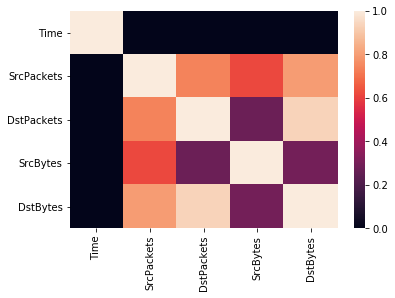

In [43]:
# The visual representation did make me curious about the relationship between the Src bytes 
#     the Dst bytes... the heatmap implies that there is very little correlation between the 
#     Src bytes and the Dst bytes ... i.e. "talkative" Src computers may OR may not be 
#     paired with talkative Dst computers.
#    
sns.heatmap(dfpnb.corr())

## more EDA related to your dataset here:

In [ ]:
# I mixed a variety of EDA steps into the material above.

## Describe has this EDA helped you to understand and get ready for your next step in your capstone project. How?

In [ ]:
# EDA on this data has helped me understand the types of data found in my two datasets, the 
#     relationships between some of the data and provided some additional ideas on where
#     I might want to go from here, in terms of next steps.
# In particular, I want to spend some considering what questions the data can answer
#     how the data might be visualized (I would like to explore some additional plots), and
#     I would like to see what can be accomplished by combining/correlating the data from
#     the two datasets.

# Backup code for processing the original data:

In [ ]:
# If you find a pattern of corrupted content in the column marked as object type, 
# you may replace it with some meaningful numerical content
# df['column_name'] = [ float(x.replace('old','new')) for x in df['column_name']]

# The above suggestion might be slower than using the builtin speed characteristics that come
#     from applying pandas vectorization abilities.
# In addition, the above technique only allows you to replace one string with another string
#     at a time, whereas using the .map() function allows you to replace as many strings
#     with numbers as you need.

map_dict = {'foo': 1, 'bar': 2}

s = pd.Series(['foo', 'foo', 'bar', np.nan])

s.map(map_dict)